In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Save and Load Data

## 1. Read and save data

In [2]:
TRAINDIR = 'data/train' # image folder
VALIDDIR = 'data/test'

CATEGORIES = ['REAL', 'FAKE']

IMG_SIZE = 32 # image size, change to rescale image
IMG_COLOR = 3 # image color, change to 1 for grayscale

In [3]:
training_data = []
validation_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAINDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                # img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass 
            
def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(VALIDDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                # img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                validation_data.append([new_array, class_num])
            except Exception as e:
                pass 
            
create_training_data() 
create_test_data()
def split_label(X, y, data):
    for features, label in data:
        X.append(features)
        y.append(label)
    
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, IMG_COLOR)
    y = np.array(y)
    
X = []
y = []
X_test = []
y_test = []

split_label(X, y, training_data)
split_label(X_test, y_test, validation_data)

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_out = open('X_test.pickle', 'wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle', 'wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

## 2. Load data

In [4]:
X = pickle.load(open('X.pickle', 'rb'))
y = pickle.load(open('y.pickle', 'rb'))

X_test = pickle.load(open('X_test.pickle', 'rb'))
y_test = pickle.load(open('y_test.pickle', 'rb'))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, IMG_COLOR)
y = np.array(y)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, IMG_COLOR)
y_test = np.array(y_test)

# Exploratory Data Analysis

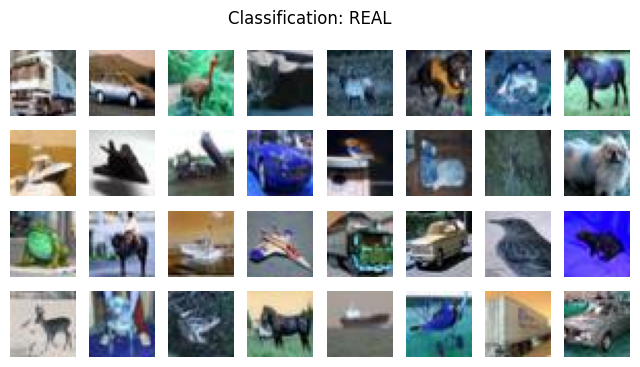

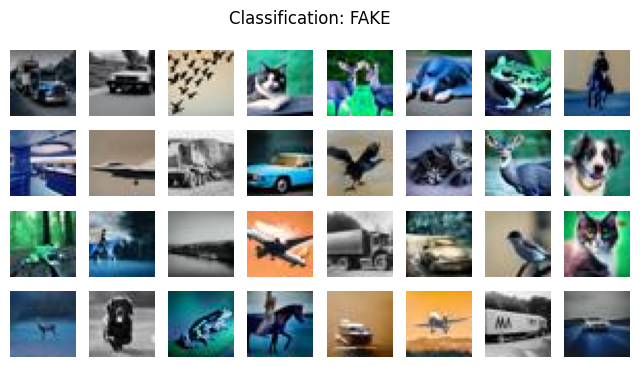

In [5]:
cat_dict = {0:'REAL', 1:'FAKE'}

for category in cat_dict:
    # Get three images for the current classification
    images = X[y==category][:32]

    # Plot the images
    fig, axes = plt.subplots(4, 8, figsize=(8, 4))

    for i, image in enumerate(images):
        axes[i//8, i%8].imshow(image)
        axes[i//8, i%8].axis('off')

    plt.suptitle(f"Classification: {cat_dict[category]}")
    plt.show()

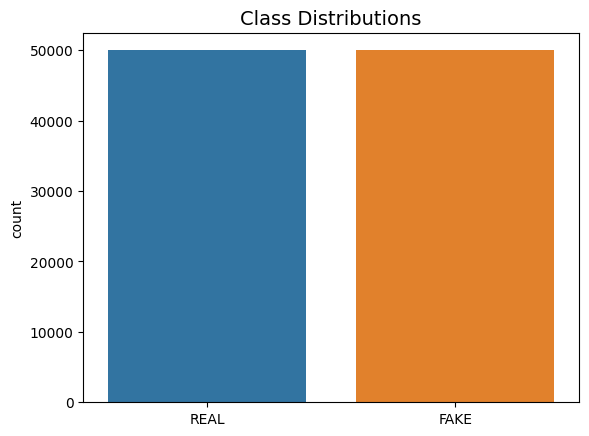

In [6]:
sns.countplot(x=y)
plt.xticks(np.arange(2), CATEGORIES)
plt.title('Class Distributions', fontsize=14)
plt.show()

# Data Preprocessing

## 1. Normalize the data

In [7]:
X = X.astype('float32')/255 # normalize

## 2. Train test split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=12, test_size=0.3)

# Model and Evaluation

In [9]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    metrics_dict = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }
    
    print(f"Accuracy : {metrics_dict['Accuracy']:.4f}")
    print(f"Precision: {metrics_dict['Precision']:.4f}")
    print(f"Recall   : {metrics_dict['Recall']:.4f}")
    print(f"F1 Score : {metrics_dict['F1 Score']:.4f}")
    print(f"ROC AUC  : {metrics_dict['ROC AUC']:.4f}")

## 1. Model

In [10]:
model = Sequential([
    
    layers.BatchNormalization(input_shape=X_train.shape[1:]), # normalize input layer
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)), # 2x2 pool size

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(), # flatten 3D feature maps to 1D feature vectors
    layers.Dense(32),

    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                        

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
2186/2188 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.7818
Epoch 1: val_loss improved from inf to 0.36146, saving model to best_model.h5
2188/2188 [==============================] - 71s 31ms/step - loss: 0.4549 - accuracy: 0.7818 - val_loss: 0.3615 - val_accuracy: 0.8436
Epoch 2/30
2186/2188 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8547
Epoch 2: val_loss improved from 0.36146 to 0.31072, saving model to best_model.h5
2188/2188 [==============================] - 66s 30ms/step - loss: 0.3397 - accuracy: 0.8547 - val_loss: 0.3107 - val_accuracy: 0.8682
Epoch 3/30
2188/2188 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8773
Epoch 3: val_loss improved from 0.31072 to 0.30165, saving model to best_model.h5
2188/2188 [==============================] - 66s 30ms/step - loss: 0.2939 - accuracy: 0.8773 - val_loss: 0.3017 - val_accuracy: 0.8777
Epoch 4/30
2186/2188 [============================>.] - ETA

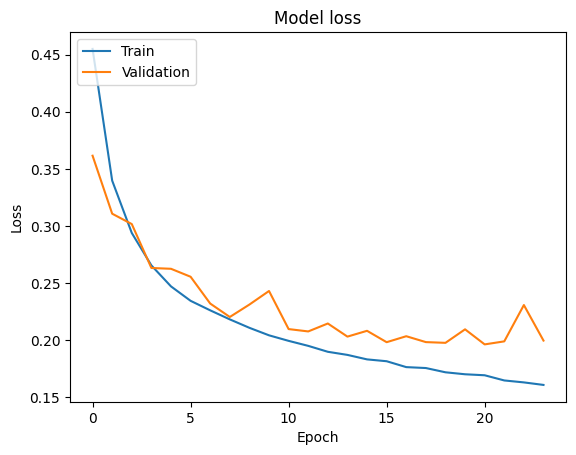

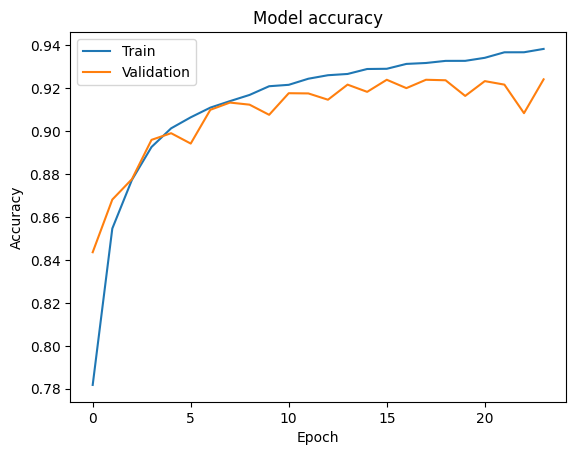

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Predict Private Test

In [13]:
model = load_model('best_model.h5')

y_pred = model.predict(X_val)  # obtain predicted class labels
y_pred = ([1 if y > 0.5 else 0 for y in y_pred])

metrics = classification_metrics(y_val, y_pred)

938/938 [==============================] - 9s 9ms/step
Accuracy : 0.9234
Precision: 0.9302
Recall   : 0.9156
F1 Score : 0.9228
ROC AUC  : 0.9234


(array([0.5, 1.5]), [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

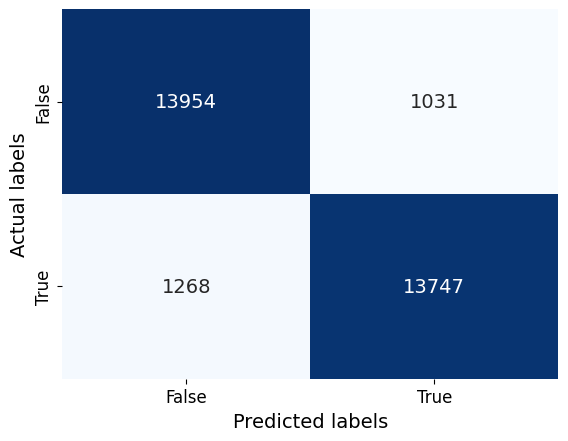

In [14]:
confusion_mtx = confusion_matrix(y_val, y_pred)

labels = ['False', 'True']
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('Actual labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## 2. Model 2 VGG-net

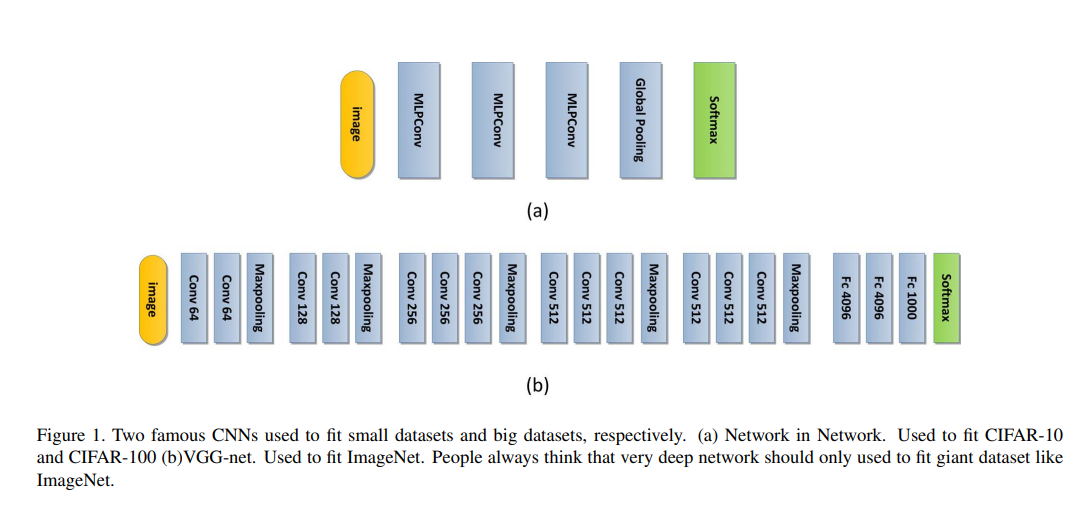 \
Kami menggunakan VGG-net, dengan susunan seperti pada Figure 1 (b), dengan sedikit penyesuaian, model kami menggunakan sigmoid activation pada layer dense terakhir.

S. Liu and W. Deng, "Very deep convolutional neural network based image classification using small training sample size," 2015 3rd IAPR Asian Conference on Pattern Recognition (ACPR), Kuala Lumpur, Malaysia, 2015, pp. 730-734, doi: 10.1109/ACPR.2015.7486599.

In [15]:
vgg_net = Sequential([
    
    layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

    layers.Flatten(), # flatten 3D feature maps to 1D feature vectors
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

vgg_net.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']) 

vgg_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg_model.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9367
Epoch 1: val_loss improved from inf to 0.19322, saving model to best_vgg_model.h5
2188/2188 [==============================] - 68s 30ms/step - loss: 0.1637 - accuracy: 0.9367 - val_loss: 0.1932 - val_accuracy: 0.9255
Epoch 2/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9366
Epoch 2: val_loss did not improve from 0.19322
2188/2188 [==============================] - 69s 31ms/step - loss: 0.1622 - accuracy: 0.9366 - val_loss: 0.1965 - val_accuracy: 0.9231
Epoch 3/30
2187/2188 [============================>.] - ETA: 0s - loss: 0.1608 - accuracy: 0.9374
Epoch 3: val_loss did not improve from 0.19322
2188/2188 [==============================] - 69s 31ms/step - loss: 0.1607 - accuracy: 0.9374 - val_loss: 0.1974 - val_accuracy: 0.9237
Epoch 4/30
2186/2188 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9384
Epoch 4: val_loss improved 

### Predict Private Test

In [17]:
model = load_model('best_vgg_model.h5')

y_pred = model.predict(X_val)  # obtain predicted class labels
y_pred = ([1 if y > 0.5 else 0 for y in y_pred])

metrics = classification_metrics(y_val, y_pred)

938/938 [==============================] - 10s 10ms/step
Accuracy : 0.9258
Precision: 0.9238
Recall   : 0.9284
F1 Score : 0.9261
ROC AUC  : 0.9258


(array([0.5, 1.5]), [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

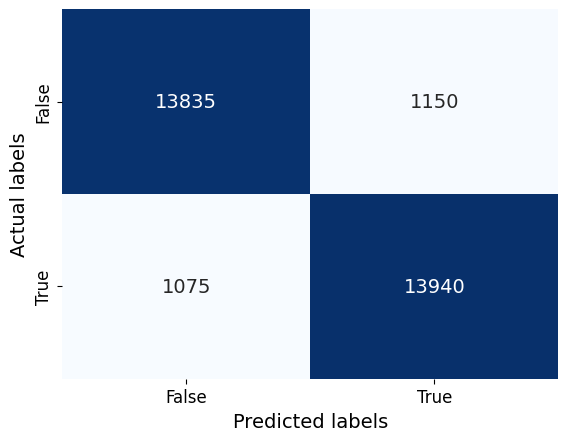

In [18]:
confusion_mtx = confusion_matrix(y_val, y_pred)

labels = ['False', 'True']
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('Actual labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Predict

In [19]:
X_test = X_test.astype('float32')/255

In [20]:
model = load_model('best_vgg_model.h5')

y_pred = model.predict(X_test)  # obtain predicted class labels
y_pred = ([1 if y > 0.5 else 0 for y in y_pred])

metrics = classification_metrics(y_test, y_pred)

625/625 [==============================] - 6s 9ms/step
Accuracy : 0.9282
Precision: 0.9273
Recall   : 0.9291
F1 Score : 0.9282
ROC AUC  : 0.9282


(array([0.5, 1.5]), [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

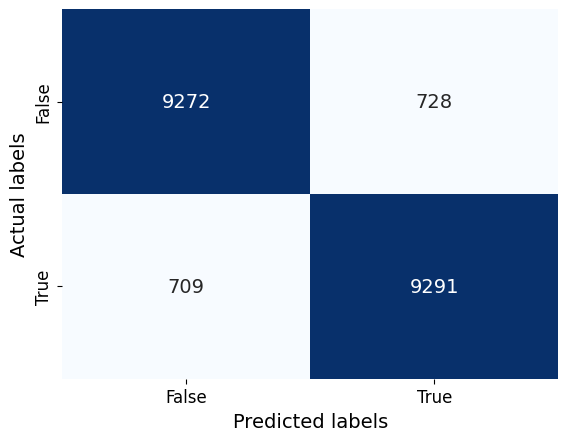

In [21]:
confusion_mtx = confusion_matrix(y_test, y_pred)

labels = ['False', 'True']
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('Actual labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)